In [2]:
import numpy as np
import os
import pandas as pd
from pathlib import Path
import scipy.io
import h5py
import sklearn
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import scipy.stats as stats
from scipy.stats import ttest_ind, mannwhitneyu

# **Load data and reconstruct matrices**

In [3]:
data_raw = pd.read_csv('data_raw_nmm_new.csv')
data_harm = pd.read_csv('data_harm_nmm_new.csv')
roi_data_harm = pd.read_csv('roi_data_harm_nmm_new.csv')
strat_covars = pd.read_csv('MatchedData01.csv')

In [4]:
#reconstruct the matrices from harmonized data

n_matrices, upper_triangle_size = data_harm.shape
N = int((1 + np.sqrt(1 + 8 * upper_triangle_size)) // 2)
matrices_harm = np.zeros((n_matrices, N, N))

for i in range(n_matrices):
  matrix = np.eye(N)
  upper_indices = np.triu_indices(N, k=1)
  matrix[upper_indices] = data_harm.iloc[i]
  matrix = matrix + matrix.T
  np.fill_diagonal(matrix, 1)
  matrices_harm[i] = matrix

matrices_harm[0]

array([[1.        , 0.36414456, 0.16021686, ..., 0.35268464, 0.17303163,
        0.34935606],
       [0.36414456, 1.        , 0.17663766, ..., 0.3294645 , 0.13063329,
        0.32313419],
       [0.16021686, 0.17663766, 1.        , ..., 0.18293571, 0.12041348,
        0.13886212],
       ...,
       [0.35268464, 0.3294645 , 0.18293571, ..., 1.        , 0.35061332,
        0.69634862],
       [0.17303163, 0.13063329, 0.12041348, ..., 0.35061332, 1.        ,
        0.53806154],
       [0.34935606, 0.32313419, 0.13886212, ..., 0.69634862, 0.53806154,
        1.        ]], shape=(122, 122))

In [5]:
matrices_harm.shape

(1106, 122, 122)

In [6]:
#reconstruct the matrices from raw data

n_matrices, upper_triangle_size = data_raw.shape
N = int((1 + np.sqrt(1 + 8 * upper_triangle_size)) // 2)
matrices_raw = np.ones((n_matrices, N, N))

for i in range(n_matrices):
  matrix = np.eye(N)
  upper_indices = np.triu_indices(N, k=1)
  matrix[upper_indices] = data_raw.iloc[i]
  matrix = matrix + matrix.T
  np.fill_diagonal(matrix, 1)
  matrices_raw[i] = matrix

matrices_raw[0]

array([[1.        , 0.40247166, 0.15385961, ..., 0.37754692, 0.19701547,
        0.43139208],
       [0.40247166, 1.        , 0.19785642, ..., 0.30233909, 0.12594017,
        0.32851803],
       [0.15385961, 0.19785642, 1.        , ..., 0.20396059, 0.11533038,
        0.14934882],
       ...,
       [0.37754692, 0.30233909, 0.20396059, ..., 1.        , 0.33867755,
        0.67002179],
       [0.19701547, 0.12594017, 0.11533038, ..., 0.33867755, 1.        ,
        0.52662347],
       [0.43139208, 0.32851803, 0.14934882, ..., 0.67002179, 0.52662347,
        1.        ]], shape=(122, 122))

In [7]:
matrices_raw.shape

(1106, 122, 122)

In [8]:
# Create adjacency matrices from harmonized data
adjacency_matrices = np.zeros_like(matrices_harm, dtype=int)
for i in range(matrices_harm.shape[0]):
  threshold = np.percentile(matrices_harm[i], 70)
  adjacency_matrices[i] = (matrices_harm[i] >= threshold).astype(int)

In [9]:
masked_matrices_harm = matrices_harm * adjacency_matrices


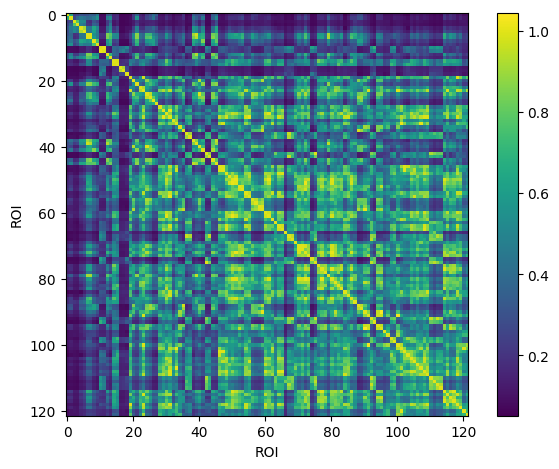

In [45]:
# Visualize an example adjacency matrix
plt.imshow(matrices_harm[3], cmap='viridis')
plt.xlabel('ROI')
plt.ylabel('ROI')
plt.colorbar()
plt.tight_layout()  # Optional: adjusts layout to prevent clipping
plt.savefig('simmatrix.png', dpi=300)  # Save at 300 DPI
plt.show()


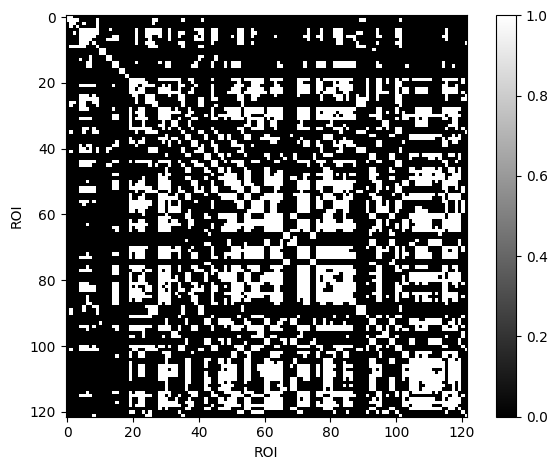

In [11]:
# Visualize an example adjacency matrix
plt.imshow(adjacency_matrices[1], cmap='gray')
plt.xlabel('ROI')
plt.ylabel('ROI')
plt.colorbar()
plt.tight_layout()  # Optional: adjusts layout to prevent clipping
plt.savefig('adjatrix.png', dpi=300)  # Save at 300 DPI
plt.show()


In [12]:
# n_subjects, n_nodes, _ = matrices_harm.shape
# n_edges = n_nodes * (n_nodes - 1) // 2
# n_active = int(n_edges * 0.095)

# # Set seed for reproducibility
# np.random.seed(2)

# # Select random 10% of upper triangle indices (excluding diagonal)
# triu_idx = np.triu_indices(n_nodes, k=1)
# selected = np.random.choice(len(triu_idx[0]), size=n_active, replace=False)

# # Create one symmetric pattern
# pattern = np.zeros((n_nodes, n_nodes), dtype=int)
# rows, cols = triu_idx[0][selected], triu_idx[1][selected]
# pattern[rows, cols] = 1
# pattern[cols, rows] = 1  # Mirror to lower triangle

# # Tile the same pattern across all subjects
# adjacency_matrices_random = np.tile(pattern, (n_subjects, 1, 1))

# for m in adjacency_matrices_random:
#     np.fill_diagonal(m, 1)

# **PyTorch Geometric**

In [13]:
import torch
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
import os


In [14]:
class MindDataset(InMemoryDataset):
    def __init__(self, root, matrices_harm, strat_covars, adjacency_matrices, roi_data, transform=None, pre_transform=None):
        self.roi_data = roi_data
        self.matrices_harm = matrices_harm
        self.strat_covars = strat_covars
        self.adjacency_matrices = adjacency_matrices
        super().__init__(root, transform, pre_transform)


        self.data, self.slices = torch.load(self.processed_paths[0], weights_only = False)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list = []
        # num_rois = matrices_harm[0].shape[0]

        for i in range(len(matrices_harm)):
            # Node features: all elements in a row
            node_features = torch.tensor(self.matrices_harm[i], dtype=torch.float)
            roi_features = torch.tensor(self.roi_data.iloc[i].values, dtype=torch.float).unsqueeze(1)
            # roi_onehot = torch.eye(num_rois, dtype=torch.float)

            
            age = self.strat_covars['Age'].iloc[i]
            age_gender_features = torch.tensor([[age]] * self.matrices_harm[i].shape[0], dtype=torch.float)
            node_features = torch.cat([node_features, age_gender_features, roi_features], dim=1)

            edge_index = torch.tensor(np.array(np.where(self.adjacency_matrices[i] == 1)), dtype=torch.long)

            edge_attr = []
            for j in range(edge_index.shape[1]):
                edge_attr.append(torch.tensor(self.matrices_harm[i][edge_index[0, j], edge_index[1, j]], dtype=torch.float))
            edge_attr = torch.stack(edge_attr).unsqueeze(1)

            data = Data(x=node_features, edge_index=edge_index, edge_attr = edge_attr, y=torch.tensor(self.strat_covars['Dx'].iloc[i], dtype=torch.long)) #WITH EDGE ATTRIBUTES
            # data = Data(x=node_features, edge_index=edge_index, y=torch.tensor(self.strat_covars['Dx'].iloc[i], dtype=torch.long))
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def len(self):
        return super().len()

    def get(self, idx):
        return super().get(idx)

In [ ]:
# n_subjects, n_nodes, _ = matrices_harm.shape
# n_edges = n_nodes * (n_nodes - 1) // 2
# n_active = int(n_edges * 0.095)

# for i in range(10):
#     # Set seed for reproducibility
#     np.random.seed(i)

#     # Select random 10% of upper triangle indices (excluding diagonal)
#     triu_idx = np.triu_indices(n_nodes, k=1)
#     selected = np.random.choice(len(triu_idx[0]), size=n_active, replace=False)

#     # Create one symmetric pattern
#     pattern = np.zeros((n_nodes, n_nodes), dtype=int)
#     rows, cols = triu_idx[0][selected], triu_idx[1][selected]
#     pattern[rows, cols] = 1
#     pattern[cols, rows] = 1  # Mirror to lower triangle

#     # Tile the same pattern across all subjects
#     adjacency_matrices_random = np.tile(pattern, (n_subjects, 1, 1))

#     for m in adjacency_matrices_random:
#         np.fill_diagonal(m, 1)

#     print(f'Dataset: {i}')

#     dataset = MindDataset(root=f'/content/drive/MyDrive/TESI/Datasets/MindDatasetNMM90random{i}_justMIND',
#                       matrices_harm=matrices_harm,
#                       strat_covars=strat_covars,
#                       adjacency_matrices=adjacency_matrices_random,
#                       roi_data = roi_data_harm)

#     print('====================')



Dataset: 0


KeyboardInterrupt: 

In [10]:
thresholds = [10, 30, 50, 70, 90]
mind_datasets = {}

for threshold in thresholds:
    # Compute adjacency matrices for current threshold
    adjacency_matrices = np.zeros_like(matrices_harm, dtype=int)
    for i in range(matrices_harm.shape[0]):
        current_threshold = np.percentile(matrices_harm[i], threshold)
        adjacency_matrices[i] = (matrices_harm[i] >= current_threshold).astype(int)

    # Define unique root path for each threshold
    dataset_root = f'Datasets/CV/MindDatasetNMM{threshold}mind_NOSEX'

    # Create and process dataset
    dataset = MindDataset(
        root=dataset_root,
        matrices_harm=matrices_harm,
        strat_covars=strat_covars,
        adjacency_matrices=adjacency_matrices,
        roi_data=roi_data_harm
    )


Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [16]:
dataset_root = f'Datasets/MindDatasetNMM70mind_age_roi'

    # Create and process dataset
dataset = MindDataset(
    root=dataset_root,
    matrices_harm=matrices_harm,
    strat_covars=strat_covars,
    adjacency_matrices=adjacency_matrices,
    roi_data=roi_data_harm
)

In [17]:
dataset[0]

Data(x=[122, 124], edge_index=[2, 4466], y=[1])

In [18]:
dataset.x

tensor([[ 1.0000,  0.3641,  0.1602,  ...,  0.3494, 26.0000,  0.0622],
        [ 0.3641,  1.0000,  0.1766,  ...,  0.3231, 26.0000,  0.0666],
        [ 0.1602,  0.1766,  1.0000,  ...,  0.1389, 26.0000,  0.1785],
        ...,
        [ 0.1431,  0.1482,  0.1337,  ...,  0.3077, 32.0000,  0.5424],
        [ 0.0893,  0.0981,  0.1133,  ...,  0.4667, 32.0000,  0.1839],
        [ 0.0748,  0.0926,  0.1015,  ...,  1.0000, 32.0000,  0.1722]])

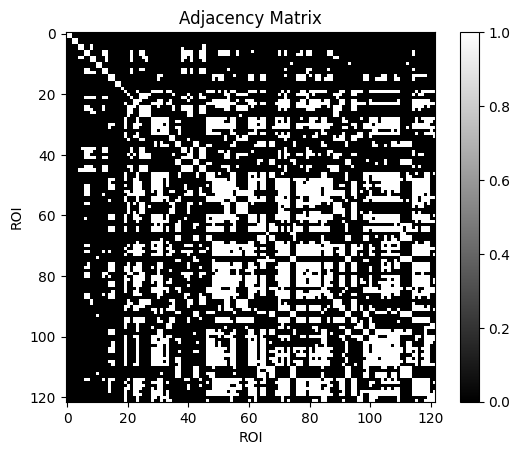

In [22]:
# Plot again the adjacency matrix just to verify that the edge indices are correct
# Get the edge index
edge_index = dataset[3].edge_index.numpy()

# Create an empty binary matrix
num_nodes = dataset[0].num_nodes
binary_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

binary_matrix[edge_index[0], edge_index[1]] = 1

# Visualize the binary matrix
plt.imshow(binary_matrix, cmap='gray')
plt.title(f'Adjacency Matrix')
plt.xlabel('ROI')
plt.ylabel('ROI')
plt.colorbar()
plt.show()

In [23]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MindDataset(1106):
Number of graphs: 1106
Number of features: 124
Number of classes: 2


In [24]:
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[122, 124], edge_index=[2, 4466], y=[1])
Number of nodes: 122
Number of edges: 4466
Average node degree: 36.61
Has isolated nodes: True
Has self-loops: True
Is undirected: True


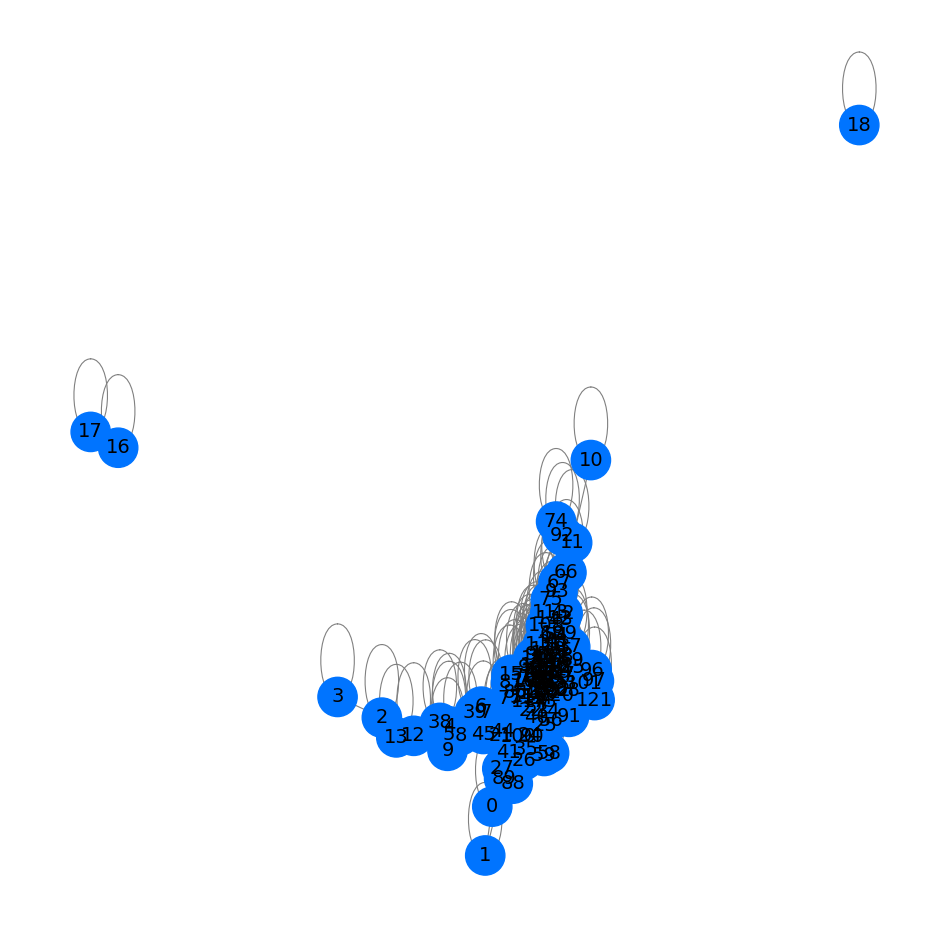

In [43]:
import networkx as nx
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')

node_colors = [data.y.item()] * data.num_nodes

nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=node_colors,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

# **BIG LOOP RANDOM**

In [25]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train():
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        all_preds.append(out.argmax(dim=1).cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds)
    train_loss = epoch_loss / len(train_loader)

    return accuracy, train_loss, f1

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y)
            total_loss += loss.item()
            all_preds.append(out.argmax(dim=1).cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # Calculate metrics
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds)
    val_loss = total_loss / len(loader)

    return accuracy, val_loss, f1, all_preds, all_labels

In [31]:
thresholds = [50]

In [32]:
for i in thresholds:

    adjacency_matrices = np.zeros_like(matrices_harm, dtype=int)
    for idx in range(matrices_harm.shape[0]):
        threshold_value = np.percentile(matrices_harm[idx], i)
        adjacency_matrices[idx] = (matrices_harm[idx] >= threshold_value).astype(int)
        
    dataset = MindDataset(
        root=f'Datasets/CV/MindDatasetNMM{i}mind_NOSEX',
        matrices_harm=matrices_harm,
        strat_covars=strat_covars,
        adjacency_matrices=adjacency_matrices,
        roi_data=roi_data_harm
    )

    print(f'Dataset: {i}')
    print('====================')


    # TRAIN TEST SPLIT
    from sklearn.model_selection import train_test_split

    train_indices, temp_indices = train_test_split(range(len(dataset)), test_size=0.3, random_state=3)
    val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=3)

    drop_fraction_healthy = 0.3
    drop_fraction_bd = 0.3

    train_covars = strat_covars.iloc[train_indices]

    healthy_to_drop = train_covars[
        (train_covars['Dx'] == 0) &
        (train_covars['Age'] >= 15) &
        (train_covars['Age'] <= 30)
    ].sample(frac=drop_fraction_healthy, random_state=42)

    bd_to_drop = train_covars[
        (train_covars['Dx'] == 1) &
        (train_covars['Age'] >= 40) &
        (train_covars['Age'] <= 60)
    ].sample(frac=drop_fraction_bd, random_state=42)


    indices_to_remove = set(healthy_to_drop.index).union(set(bd_to_drop.index))
    train_indices_new = [idx for idx in train_indices if idx not in indices_to_remove]

    train_loader = DataLoader(dataset[train_indices_new], batch_size=32, shuffle=True)
    val_loader = DataLoader(dataset[val_indices], batch_size=32, shuffle=False)
    test_loader = DataLoader(dataset[test_indices], batch_size=32, shuffle=False)

    # TRAINING
    num_layers_list = [2, 3, 4]
    hidden_dims_list = [32, 64, 128]
    norm_types_list = ["layer","node_n", "node_v", "node_m","node_srv","node_pr_2"] #
    param_grid = list(product(num_layers_list, hidden_dims_list, norm_types_list))

    best_val_acc = 0
    best_params = None
    best_model_path = "best_grid_model_1.pt"
    results = []


    for num_layers, hidden_dim, norm_type in param_grid:
        print(f"\nTraining with num_layers={num_layers}, hidden_dim={hidden_dim}, norm_type={norm_type}")

        set_seed(42)

        model = GCN(dataset.num_features, hidden_dim=hidden_dim, output_dim=dataset.num_classes, num_layers=num_layers, norm_type=norm_type)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        patience = 20
        best_val_loss = float("inf")
        patience_counter = 0

        for epoch in range(100):
            train_acc, train_loss, train_f1 = train()
            val_acc, val_loss, val_f1, _, _ = evaluate(val_loader)

            # print(
            #     f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
            #     f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}"
            # )

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), "temp_model_1.pt")  # Save the best model for this config
                print(f"Saved best model at epoch {epoch} with Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # Load best model for this configuration
        model.load_state_dict(torch.load("temp_model_1.pt"))
        test_acc, test_loss, test_f1,_,_ = evaluate(test_loader)
        results.append({
                    "num_layers": num_layers,
                    "hidden_dim": hidden_dim,
                    "norm_type": norm_type,
                    "test_accuracy": test_acc,
                    "test_loss": test_loss,
                    "test_f1": test_f1
                })

        print(f"For num_layers={num_layers}, hidden_dim={hidden_dim}: Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")

        df_results = pd.DataFrame(results)
        df_results_correct = df_results['test_accuracy'].round(4)*100
        print(df_results_correct)

        # Update best model if current one is better
        if test_acc > best_val_acc:
            best_val_acc = test_acc
            best_params = (num_layers, hidden_dim, norm_type)
            torch.save(model.state_dict(), best_model_path)  # Save the best model

    # Final results
    print(f"\nBest Model: num_layers={best_params[0]}, hidden_dim={best_params[1]},  norm_type={best_params[2]} with Accuracy={best_val_acc:.4f}")
    df_results = pd.DataFrame(results)
    df_results_correct = df_results['test_accuracy'].round(4)*100
    df_results_correct



Dataset: 50

Training with num_layers=2, hidden_dim=32, norm_type=layer
Saved best model at epoch 0 with Train Loss: 0.6939, Train Accuracy: 0.5158, Train F1: 0.4996, Val Loss: 0.6846, Val Accuracy: 0.5663, Val F1: 0.5484
Saved best model at epoch 1 with Train Loss: 0.6918, Train Accuracy: 0.5233, Train F1: 0.4220, Val Loss: 0.6683, Val Accuracy: 0.5602, Val F1: 0.4023
Saved best model at epoch 10 with Train Loss: 0.6946, Train Accuracy: 0.5429, Train F1: 0.5216, Val Loss: 0.6681, Val Accuracy: 0.5602, Val F1: 0.4023
Saved best model at epoch 19 with Train Loss: 0.6875, Train Accuracy: 0.5594, Train F1: 0.5128, Val Loss: 0.6680, Val Accuracy: 0.5602, Val F1: 0.4023
Saved best model at epoch 20 with Train Loss: 0.6878, Train Accuracy: 0.5188, Train F1: 0.5126, Val Loss: 0.6674, Val Accuracy: 0.5602, Val F1: 0.4023
Saved best model at epoch 25 with Train Loss: 0.6851, Train Accuracy: 0.5459, Train F1: 0.5176, Val Loss: 0.6653, Val Accuracy: 0.5602, Val F1: 0.4023
Saved best model at epoc

In [ ]:
df_results_correct

,test_accuracy
0,54.82
1,54.82
2,54.82
3,56.02
4,63.86
5,63.86
6,54.82
7,54.82
8,54.82
9,54.82


# **Dataset for Gender Prediction**

In [ ]:

class MindDataset(InMemoryDataset):
    def __init__(self, root, matrices_harm, strat_covars, adjacency_matrices, roi_data, transform=None, pre_transform=None):
        self.roi_data = roi_data
        self.matrices_harm = matrices_harm
        self.strat_covars = strat_covars
        self.adjacency_matrices = adjacency_matrices
        super().__init__(root, transform, pre_transform)


        self.data, self.slices = torch.load(self.processed_paths[0], weights_only = False)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list = []
        # num_rois = self.matrices_harm[0].shape[0]

        for i in range(len(matrices_harm)):

            node_features = torch.tensor(self.matrices_harm[i], dtype=torch.float)
            # roi_onehot = torch.eye(num_rois, dtype=torch.float)
            roi_features = torch.tensor(self.roi_data.iloc[i].values, dtype=torch.float).unsqueeze(1)
            age = self.strat_covars['Age'].iloc[i]
            dx = self.strat_covars['Dx'].iloc[i]
            age_dx_features = torch.tensor([[dx]] * self.matrices_harm[i].shape[0], dtype=torch.float)
            node_features = torch.cat([roi_features, age_dx_features], dim=1)

            edge_index = torch.tensor(np.array(np.where(self.adjacency_matrices[i] == 1)), dtype=torch.long)

            edge_attr = []
            for j in range(edge_index.shape[1]):
                edge_attr.append(torch.tensor(self.matrices_harm[i][edge_index[0, j], edge_index[1, j]], dtype=torch.float))
            edge_attr = torch.stack(edge_attr).unsqueeze(1)

            data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor(self.strat_covars['Gender'].iloc[i], dtype=torch.long))
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def len(self):
        return super().len()

    def get(self, idx):
        return super().get(idx)

Processing...
Done!


In [ ]:
dataset = MindDataset(root='/content/drive/MyDrive/TESI/DatasetsMindDatasetNMM10genderedgeeverything',
                      matrices_harm=matrices_harm,
                      strat_covars=strat_covars,
                      adjacency_matrices=adjacency_matrices,
                      roi_data = roi_data_harm)

In [ ]:
dataset[0]

Data(x=[122, 2], edge_index=[2, 13396], edge_attr=[13396, 1], y=[1])

# **Train-test split**

In [ ]:
from sklearn.model_selection import train_test_split

train_indices, temp_indices = train_test_split(range(len(dataset)), test_size=0.3, random_state=3)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=3)

train_loader = DataLoader(dataset[train_indices], batch_size=32, shuffle=True)
val_loader = DataLoader(dataset[val_indices], batch_size=32, shuffle=False)
test_loader = DataLoader(dataset[test_indices], batch_size=32, shuffle=False)

In [ ]:
counts = torch.bincount(train_loader.dataset.y)
print(counts)
print(counts[0]/sum(counts))
counts = torch.bincount(val_loader.dataset.y)
print(counts)
print(counts[0]/sum(counts))
counts = torch.bincount(test_loader.dataset.y)
print(counts)
print(counts[0]/sum(counts))


tensor([421, 353])
tensor(0.5439)
tensor([93, 73])
tensor(0.5602)
tensor([91, 75])
tensor(0.5482)


In [ ]:
for data in train_loader:
    print(data)
    break

DataBatch(x=[3904, 125], edge_index=[2, 48768], edge_attr=[48768, 1], y=[32], batch=[3904], ptr=[33])


### Age train test split

In [9]:
from sklearn.model_selection import train_test_split

train_indices, temp_indices = train_test_split(range(len(dataset)), test_size=0.3, random_state=3)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=3)

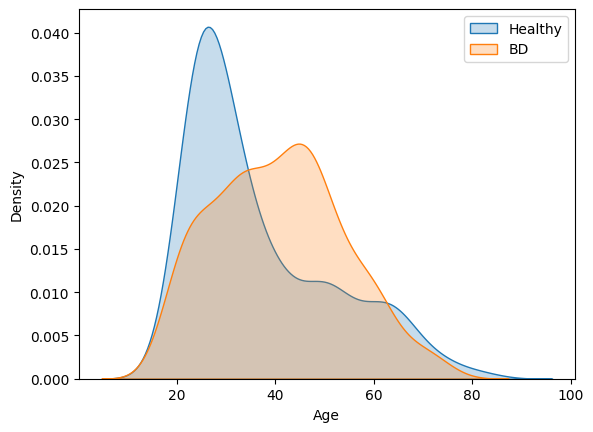

In [47]:
# Extract the training set covariates
# train_covars = strat_covars.iloc[train_indices]

# Filter by diagnosis
healthy_ages = strat_covars[strat_covars['Dx'] == 0]['Age']
bd_ages = strat_covars[strat_covars['Dx'] == 1]['Age']

# Create the plot
sns.kdeplot(healthy_ages, label='Healthy', fill=True)
sns.kdeplot(bd_ages, label='BD', fill=True)
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.savefig('age_distribution_pre.png', dpi = 300)
plt.show()

In [11]:
from scipy.stats import ttest_ind

age_diagnosis_0 = train_covars[train_covars['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars[train_covars['Dx'] == 1]['Age']

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -3.4399040673474155, P-value: 0.0006132171289379553


In [12]:
from scipy.stats import mannwhitneyu

age_diagnosis_0 = strat_covars[strat_covars['Dx'] == 0]['Age']
age_diagnosis_1 = strat_covars[strat_covars['Dx'] == 1]['Age']

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')

print(f"U-statistic: {u_stat}, P-value: {p_value}")

U-statistic: 120173.5, P-value: 2.9196695036136526e-09


In [13]:
import numpy as np

# Define drop fractions
drop_fraction_healthy = 0.3
drop_fraction_bd = 0.3

train_covars = strat_covars.iloc[train_indices]

# Identify subjects to drop
healthy_to_drop = train_covars[
    (train_covars['Dx'] == 0) &
    (train_covars['Age'] >= 15) &
    (train_covars['Age'] <= 30)
].sample(frac=drop_fraction_healthy, random_state=42)

bd_to_drop = train_covars[
    (train_covars['Dx'] == 1) &
    (train_covars['Age'] >= 40) &
    (train_covars['Age'] <= 60)
].sample(frac=drop_fraction_bd, random_state=42)


indices_to_remove = set(healthy_to_drop.index).union(set(bd_to_drop.index))

# Create the new train indices excluding these subjects
train_indices_new = [idx for idx in train_indices if idx not in indices_to_remove]


print(f"Removed {len(indices_to_remove)} subjects.")
print(f"New training set size: {len(train_indices_new)}")


Removed 109 subjects.
New training set size: 665


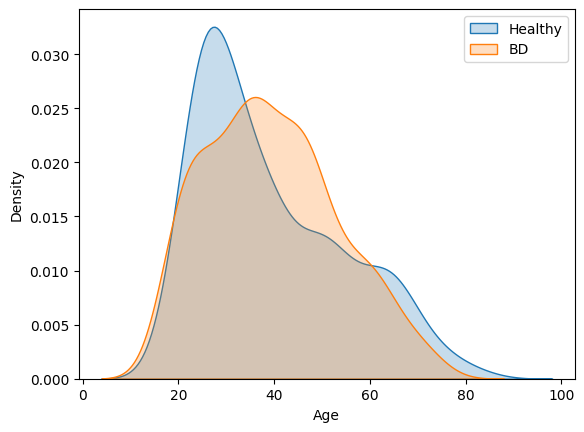

In [14]:
# Extract the training set covariates
train_covars_new = strat_covars.iloc[train_indices_new]

# Filter by diagnosis
healthy_ages = train_covars_new[train_covars_new['Dx'] == 0]['Age']
bd_ages = train_covars_new[train_covars_new['Dx'] == 1]['Age']

# Create the plot
sns.kdeplot(healthy_ages, label='Healthy', fill=True)
sns.kdeplot(bd_ages, label='BD', fill=True)
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.savefig('age_distribution_post.png', dpi = 300)
plt.show()

In [15]:
from scipy.stats import ttest_ind

age_diagnosis_0 = train_covars_new[train_covars_new['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars_new[train_covars_new['Dx'] == 1]['Age']

t_stat, p_value = ttest_ind(age_diagnosis_0, age_diagnosis_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -0.19606813069376083, P-value: 0.8446170947943139


In [16]:
from scipy.stats import mannwhitneyu

age_diagnosis_0 = train_covars_new[train_covars_new['Dx'] == 0]['Age']
age_diagnosis_1 = train_covars_new[train_covars_new['Dx'] == 1]['Age']

u_stat, p_value = mannwhitneyu(age_diagnosis_0, age_diagnosis_1, alternative='two-sided')

print(f"U-statistic: {u_stat}, P-value: {p_value}")

U-statistic: 52730.5, P-value: 0.37945085671835976


In [17]:
train_loader = DataLoader(dataset[train_indices_new], batch_size=32, shuffle=True)
val_loader = DataLoader(dataset[val_indices], batch_size=32, shuffle=False)
test_loader = DataLoader(dataset[test_indices], batch_size=32, shuffle=False)

In [18]:
counts = torch.bincount(train_loader.dataset.y)
print(counts)
print(counts[0]/sum(counts))
counts = torch.bincount(val_loader.dataset.y)
print(counts)
print(counts[0]/sum(counts))
counts = torch.bincount(test_loader.dataset.y)
print(counts)
print(counts[0]/sum(counts))


tensor([360, 305])
tensor(0.5414)
tensor([93, 73])
tensor(0.5602)
tensor([91, 75])
tensor(0.5482)


In [19]:
for data in train_loader:
    print(data)
    break

DataBatch(x=[3904, 124], edge_index=[2, 142912], edge_attr=[142912, 1], y=[32], batch=[3904], ptr=[33])


# **Graph Neural Networks**

In [26]:
#Graph Convolutional Network
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch import Tensor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from itertools import product

### GAT + BatchNorm and DropOut

In [ ]:
from torch_geometric.nn import GATConv, global_add_pool

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, heads=4, dropout=0.5):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        self.dropout = torch.nn.Dropout(dropout)

        # Input layer
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout))
        self.bns.append(BatchNorm1d(hidden_channels * heads))  # Adjusted for multi-head output

        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout))
            self.bns.append(BatchNorm1d(hidden_channels * heads))

        # Output layer (single head for classification)
        self.conv_out = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index, batch):
        batch_size = batch.max().item() + 1

        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index).relu()
            x = bn(x)  # Apply Batch Normalization
            x = self.dropout(x)  # Apply Dropout

        x = self.conv_out(x, edge_index)
        x = global_add_pool(x, batch, size=batch_size)

        return x

# Instantiate the model
model = GAT(dataset.num_features, 32, dataset.num_classes, num_layers=3)
print(model)


GAT(
  (convs): ModuleList(
    (0): GATConv(122, 32, heads=4)
    (1-2): 2 x GATConv(128, 32, heads=4)
  )
  (bns): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (conv_out): GATConv(128, 2, heads=1)
)


### GIN

In [ ]:
from torch_geometric.nn import MLP, GINConv, global_add_pool

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            mlp = MLP([in_channels, hidden_channels, hidden_channels])
            self.convs.append(GINConv(nn=mlp, train_eps=False))
            in_channels = hidden_channels

        self.mlp = MLP([hidden_channels, hidden_channels, out_channels],
                       norm=None, dropout=0.5)

    def forward(self, x, edge_index, batch):

        batch_size = batch.max().item() + 1

        for conv in self.convs:
            x = conv(x, edge_index).relu()

        x = global_add_pool(x, batch, size=batch_size)
        return self.mlp(x)


model = GIN(dataset.num_features, 16, dataset.num_classes, 2)
print(model)

GIN(
  (convs): ModuleList(
    (0): GINConv(nn=MLP(125, 16, 16))
    (1): GINConv(nn=MLP(16, 16, 16))
  )
  (mlp): MLP(16, 16, 2)
)


### GIN + BatchNorm and DropOut

In [ ]:
from torch_geometric.nn import MLP, GINConv, global_add_pool
from torch.nn import BatchNorm1d

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout=0.5):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        for _ in range(num_layers):
            mlp = MLP([in_channels, hidden_channels, hidden_channels])
            self.convs.append(GINConv(nn=mlp, train_eps=False))
            self.bns.append(BatchNorm1d(hidden_channels))
            in_channels = hidden_channels

        self.mlp = MLP([hidden_channels, hidden_channels, out_channels], norm=None, dropout=dropout)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index, batch):
        batch_size = batch.max().item() + 1

        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index).relu()
            x = bn(x)
            x = self.dropout(x)

        x = global_mean_pool(x, batch, size=batch_size)
        return self.mlp(x)

model = GIN(dataset.num_features, 16, dataset.num_classes, num_layers=2)
print(model)


GIN(
  (convs): ModuleList(
    (0): GINConv(nn=MLP(122, 16, 16))
    (1): GINConv(nn=MLP(16, 16, 16))
  )
  (bns): ModuleList(
    (0-1): 2 x BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp): MLP(16, 16, 2)
  (dropout): Dropout(p=0.5, inplace=False)
)


### GCN + Node Norm

In [27]:
import torch.nn as nn

class NodeNorm(nn.Module):
    def __init__(self, nn_type="n", unbiased=False, eps=1e-5, power_root=2):
        super(NodeNorm, self).__init__()
        self.unbiased = unbiased
        self.eps = eps
        self.nn_type = nn_type
        self.power = 1 / power_root

    def forward(self, x):
        if self.nn_type == "n":
            mean = torch.mean(x, dim=1, keepdim=True)
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = (x - mean) / std
        elif self.nn_type == "v":
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / std
        elif self.nn_type == "m":
            mean = torch.mean(x, dim=1, keepdim=True)
            x = x - mean
        elif self.nn_type == "srv":  # square root of variance
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / torch.sqrt(std)
        elif self.nn_type == "pr":
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / torch.pow(std, self.power)
        return x

    def __repr__(self):
        original_str = super().__repr__()
        components = list(original_str)
        nn_type_str = f"nn_type={self.nn_type}"
        components.insert(-1, nn_type_str)
        new_str = "".join(components)
        return new_str

def get_normalization(norm_type, num_channels=None):
    if norm_type is None:
        norm = None
    elif norm_type == "batch":
        norm = nn.BatchNorm1d(num_features=num_channels)
    elif norm_type == "node_n":
        norm = NodeNorm(nn_type="n")
    elif norm_type == "node_v":
        norm = NodeNorm(nn_type="v")
    elif norm_type == "node_m":
        norm = NodeNorm(nn_type="m")
    elif norm_type == "node_srv":
        norm = NodeNorm(nn_type="srv")
    elif norm_type.find("node_pr") != -1:
        power_root = norm_type.split("_")[-1]
        power_root = int(power_root)
        norm = NodeNorm(nn_type="pr", power_root=power_root)
    elif norm_type == "layer":
        norm = nn.LayerNorm(normalized_shape=num_channels)
    else:
        raise NotImplementedError
    return norm


In [28]:
from torch.nn import BatchNorm1d, Dropout

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, norm_type="node_n"):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.bns.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))

        self.fc = Linear(hidden_dim, output_dim)
        # self.dropout = Dropout(dropout_rate)

    def forward(self, x, edge_index, batch):

        for conv, bn in zip(self.convs, self.bns):
            x = F.relu(conv(x, edge_index))
            x = bn(x)
            # x = self.dropout(x)

        x = global_mean_pool(x, batch)

        x = self.fc(x)
        return x

In [ ]:
from torch_geometric.nn import MLP, GINConv, global_mean_pool
import torch.nn.functional as F
import torch.nn as nn

class GIN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, norm_type="batch"):
        super(GIN, self).__init__()

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        self.convs.append(GINConv(MLP([input_dim, hidden_dim, hidden_dim]), train_eps=False))
        self.norms.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))

        for _ in range(num_layers - 1):
            self.convs.append(GINConv(MLP([hidden_dim, hidden_dim, hidden_dim]), train_eps=False))
            self.norms.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))

        self.fc = MLP([hidden_dim, hidden_dim, output_dim], norm=None)

    def forward(self, x, edge_index, batch):
        for conv, norm in zip(self.convs, self.norms):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = norm(x)

        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


### Train and Test

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

patience = 20
best_val_loss = float("inf")
best_val_f1 = 0
patience_counter = 0

def train():
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        all_preds.append(out.argmax(dim=1).cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    train_loss = epoch_loss / len(train_loader)

    train_losses.append(train_loss)
    train_accuracies.append(accuracy)

    return accuracy, train_loss, f1

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y)
            total_loss += loss.item()
            all_preds.append(out.argmax(dim=1).cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # Calculate metrics
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    val_loss = total_loss / len(loader)

    val_losses.append(val_loss)
    val_accuracies.append(accuracy)

    return accuracy, val_loss, f1, all_preds, all_labels


for epoch in range(100):
    train_acc, train_loss, train_f1 = train()
    val_acc, val_loss, val_f1, _, _ = evaluate(val_loader)  # Validation set metrics
    print(
        f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print(f"Saved best model at epoch {epoch} with Val Loss: {val_loss:.4f}")
    else:
        patience_counter += 1

    # if val_f1 > best_val_f1:
    #     best_val_f1 = val_f1
    #     patience_counter = 0
    #     torch.save(model.state_dict(), "best_model.pt")
    #     print(f"Saved best model at epoch {epoch} with Val F1: {val_f1:.4f}")
    # else:
    #     patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch} as validation loss did not improve for {patience} consecutive epochs.")
        break


# Evaluate on test set after training is complete
model.load_state_dict(torch.load("best_model.pt"))
test_acc, test_loss, test_f1, test_preds, test_labels = evaluate(test_loader)
print(f"Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Set")
plt.show()


In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Train and test + Grid Search

In [29]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train():
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        all_preds.append(out.argmax(dim=1).cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    train_loss = epoch_loss / len(train_loader)

    return accuracy, train_loss, f1

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y)
            total_loss += loss.item()
            all_preds.append(out.argmax(dim=1).cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # Calculate metrics
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    val_loss = total_loss / len(loader)

    return accuracy, val_loss, f1, all_preds, all_labels

In [30]:
num_layers_list = [2, 3, 4]
hidden_dims_list = [32, 64, 128]
norm_types_list = ["layer","node_n", "node_v", "node_m","node_srv","node_pr_2"] #
param_grid = list(product(num_layers_list, hidden_dims_list, norm_types_list))

best_val_acc = 0
best_params = None
best_model_path = "best_grid_model_s1.pt"
results = []


for num_layers, hidden_dim, norm_type in param_grid:
    print(f"\nTraining with num_layers={num_layers}, hidden_dim={hidden_dim}, norm_type={norm_type}")

    set_seed(42)

    model = GCN(dataset.num_features, hidden_dim=hidden_dim, output_dim=dataset.num_classes, num_layers=num_layers, norm_type=norm_type)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    patience = 20
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(100):
        train_acc, train_loss, train_f1 = train()
        val_acc, val_loss, val_f1, _, _ = evaluate(val_loader)

        # print(
        #     f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
        #     f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}"
        # )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "temp_model_s1.pt")  # Save the best model for this config
            print(f"Saved best model at epoch {epoch} with Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Load best model for this configuration
    model.load_state_dict(torch.load("temp_model_s1.pt"))
    test_acc, test_loss, test_f1,_,_ = evaluate(test_loader)
    results.append({
                "num_layers": num_layers,
                "hidden_dim": hidden_dim,
                "norm_type": norm_type,
                "test_accuracy": test_acc,
                "test_loss": test_loss,
                "test_f1": test_f1
            })

    print(f"For num_layers={num_layers}, hidden_dim={hidden_dim}: Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")

    df_results = pd.DataFrame(results)
    df_results_correct = df_results['test_accuracy'].round(4)*100
    print(df_results_correct)

    # Update best model if current one is better
    if test_acc > best_val_acc:
        best_val_acc = test_acc
        best_params = (num_layers, hidden_dim, norm_type)
        torch.save(model.state_dict(), best_model_path)  # Save the best model

# Final results
print(f"\nBest Model: num_layers={best_params[0]}, hidden_dim={best_params[1]},  norm_type={best_params[2]} with Accuracy={best_val_acc:.4f}")
df_results = pd.DataFrame(results)
df_results_correct = df_results['test_accuracy'].round(4)*100
df_results_correct


Training with num_layers=2, hidden_dim=32, norm_type=layer
Saved best model at epoch 0 with Train Loss: 0.6939, Train Accuracy: 0.5173, Train F1: 0.5015, Val Loss: 0.6865, Val Accuracy: 0.5904, Val F1: 0.5565
Saved best model at epoch 1 with Train Loss: 0.6911, Train Accuracy: 0.5323, Train F1: 0.4197, Val Loss: 0.6701, Val Accuracy: 0.5602, Val F1: 0.4023
Saved best model at epoch 10 with Train Loss: 0.6935, Train Accuracy: 0.5474, Train F1: 0.5260, Val Loss: 0.6679, Val Accuracy: 0.5602, Val F1: 0.4023
Saved best model at epoch 20 with Train Loss: 0.6849, Train Accuracy: 0.5353, Train F1: 0.5317, Val Loss: 0.6642, Val Accuracy: 0.5602, Val F1: 0.4023
Saved best model at epoch 26 with Train Loss: 0.6813, Train Accuracy: 0.5414, Train F1: 0.5108, Val Loss: 0.6625, Val Accuracy: 0.5542, Val F1: 0.4099
Saved best model at epoch 29 with Train Loss: 0.6893, Train Accuracy: 0.5203, Train F1: 0.5162, Val Loss: 0.6608, Val Accuracy: 0.5482, Val F1: 0.4419
Saved best model at epoch 32 with Tr

KeyboardInterrupt: 

In [ ]:
df_results_correct = df_results['test_accuracy'].round(4)*100
df_results_correct

In [ ]:
df_results

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Set")
plt.show()


In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# GNNs with edge attributes

### GATv2Conv

In [ ]:
from torch_geometric.nn import GATv2Conv, BatchNorm

class GATv2Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super().__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, concat=True, edge_dim=1)
        self.norm1 = BatchNorm(hidden_channels * heads)
        self.conv2 = GATv2Conv(hidden_channels * heads, hidden_channels, concat=False, edge_dim=1)
        self.norm2 = BatchNorm(hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = self.norm1(x)
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.norm2(x)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

model = GATv2Net(dataset.num_features, 64, dataset.num_classes)
print(model)

GATv2Net(
  (conv1): GATv2Conv(1, 64, heads=4)
  (norm1): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATv2Conv(256, 64, heads=1)
  (norm2): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


### GINEConv

In [ ]:
from torch_geometric.nn import GINEConv, BatchNorm

class GINE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden_channels), torch.nn.ReLU(), torch.nn.Linear(hidden_channels, hidden_channels))
        self.conv1 = GINEConv(nn1, edge_dim = 1)
        self.norm1 = BatchNorm(hidden_channels)

        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden_channels, hidden_channels), torch.nn.ReLU(), torch.nn.Linear(hidden_channels, hidden_channels))
        self.conv2 = GINEConv(nn2, edge_dim = 1)
        self.norm2 = BatchNorm(hidden_channels)

        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = self.norm1(x)
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.norm2(x)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

model = GINE(dataset.num_features, 32, dataset.num_classes)
print(model)

GINE(
  (conv1): GINEConv(nn=Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (norm1): BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GINEConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (norm2): BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


### Node Norm

In [ ]:
import torch.nn as nn

class NodeNorm(nn.Module):
    def __init__(self, nn_type="n", unbiased=False, eps=1e-5, power_root=2):
        super(NodeNorm, self).__init__()
        self.unbiased = unbiased
        self.eps = eps
        self.nn_type = nn_type
        self.power = 1 / power_root

    def forward(self, x):
        if self.nn_type == "n":
            mean = torch.mean(x, dim=1, keepdim=True)
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = (x - mean) / std
        elif self.nn_type == "v":
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / std
        elif self.nn_type == "m":
            mean = torch.mean(x, dim=1, keepdim=True)
            x = x - mean
        elif self.nn_type == "srv":  # square root of variance
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / torch.sqrt(std)
        elif self.nn_type == "pr":
            std = (
                torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps
            ).sqrt()
            x = x / torch.pow(std, self.power)
        return x

    def __repr__(self):
        original_str = super().__repr__()
        components = list(original_str)
        nn_type_str = f"nn_type={self.nn_type}"
        components.insert(-1, nn_type_str)
        new_str = "".join(components)
        return new_str

def get_normalization(norm_type, num_channels=None):
    if norm_type is None:
        norm = None
    elif norm_type == "batch":
        norm = nn.BatchNorm1d(num_features=num_channels)
    elif norm_type == "node_n":
        norm = NodeNorm(nn_type="n")
    elif norm_type == "node_v":
        norm = NodeNorm(nn_type="v")
    elif norm_type == "node_m":
        norm = NodeNorm(nn_type="m")
    elif norm_type == "node_srv":
        norm = NodeNorm(nn_type="srv")
    elif norm_type.find("node_pr") != -1:
        power_root = norm_type.split("_")[-1]
        power_root = int(power_root)
        norm = NodeNorm(nn_type="pr", power_root=power_root)
    elif norm_type == "layer":
        norm = nn.LayerNorm(normalized_shape=num_channels)
    else:
        raise NotImplementedError
    return norm


In [ ]:
from torch.nn import BatchNorm1d, Dropout

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, norm_type="node_n"):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.bns.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(get_normalization(norm_type=norm_type, num_channels=hidden_dim))

        self.fc = Linear(hidden_dim, output_dim)
        # self.dropout = Dropout(dropout_rate)

    def forward(self, x, edge_index, edge_attr, batch):

        for conv, bn in zip(self.convs, self.bns):
            x = F.relu(conv(x, edge_index, edge_attr))
            x = bn(x)
            # x = self.dropout(x)

        x = global_mean_pool(x, batch)

        x = self.fc(x)
        return x

### Train and Test

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train():
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        all_preds.append(out.argmax(dim=1).cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    train_loss = epoch_loss / len(train_loader)

    return accuracy, train_loss, f1

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = F.cross_entropy(out, data.y)
            total_loss += loss.item()
            all_preds.append(out.argmax(dim=1).cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # Calculate metrics
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    val_loss = total_loss / len(loader)

    return accuracy, val_loss, f1, all_preds, all_labels

In [ ]:
set_seed(42)

model = GINE(dataset.num_features, 32, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


patience = 20
best_val_loss = float("inf")
best_val_f1 = 0
patience_counter = 0

for epoch in range(100):

    train_acc, train_loss, train_f1 = train()
    val_acc, val_loss, val_f1, _, _ = evaluate(val_loader)  # Validation set metrics
    print(
        f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model1.pt")
        print(f"Saved best model at epoch {epoch} with Val Loss: {val_loss:.4f}")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch} as validation loss did not improve for {patience} consecutive epochs.")
        break


# Evaluate on test set after training is complete
model.load_state_dict(torch.load("best_model1.pt"))
test_acc, test_loss, test_f1, test_preds, test_labels = evaluate(test_loader)
print(f"Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")

Epoch: 0, Train Loss: 0.6648, Train Accuracy: 0.5865, Train F1: 0.5881, Val Loss: 0.6623, Val Accuracy: 0.5964, Val F1: 0.5908
Saved best model at epoch 0 with Val Loss: 0.6623
Epoch: 1, Train Loss: 0.6370, Train Accuracy: 0.6256, Train F1: 0.6278, Val Loss: 0.5944, Val Accuracy: 0.6446, Val F1: 0.6424
Saved best model at epoch 1 with Val Loss: 0.5944
Epoch: 2, Train Loss: 0.6321, Train Accuracy: 0.6286, Train F1: 0.6300, Val Loss: 0.6771, Val Accuracy: 0.6145, Val F1: 0.5530
Epoch: 3, Train Loss: 0.6307, Train Accuracy: 0.6451, Train F1: 0.6424, Val Loss: 0.6635, Val Accuracy: 0.6205, Val F1: 0.5709
Epoch: 4, Train Loss: 0.6295, Train Accuracy: 0.6361, Train F1: 0.6318, Val Loss: 0.6429, Val Accuracy: 0.6446, Val F1: 0.6441
Epoch: 5, Train Loss: 0.6186, Train Accuracy: 0.6526, Train F1: 0.6484, Val Loss: 0.6626, Val Accuracy: 0.6265, Val F1: 0.5835
Epoch: 6, Train Loss: 0.6163, Train Accuracy: 0.6466, Train F1: 0.6406, Val Loss: 0.5702, Val Accuracy: 0.7048, Val F1: 0.7030
Saved best 

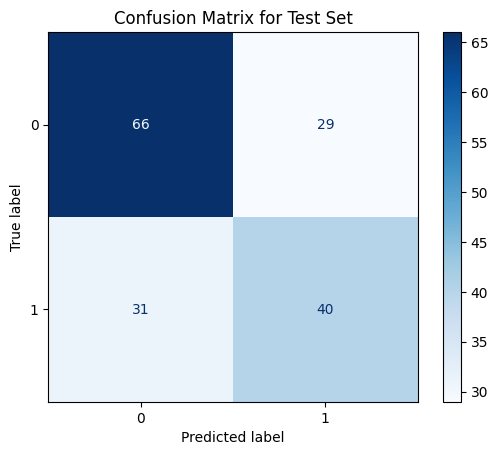

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Set")
plt.show()


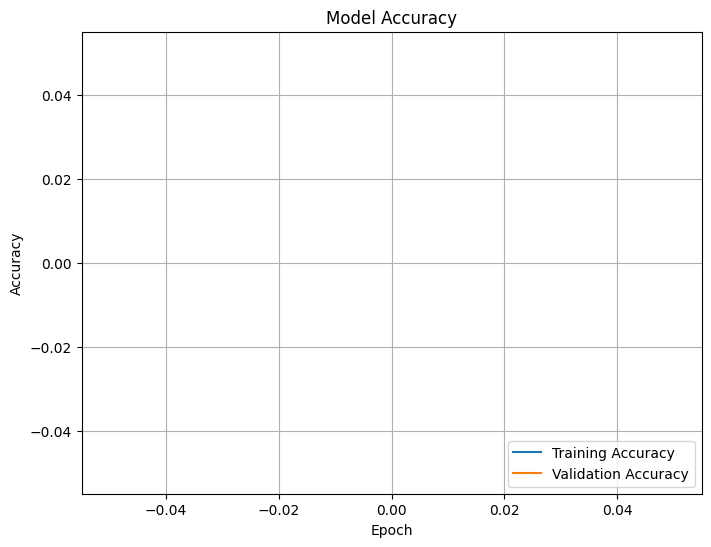

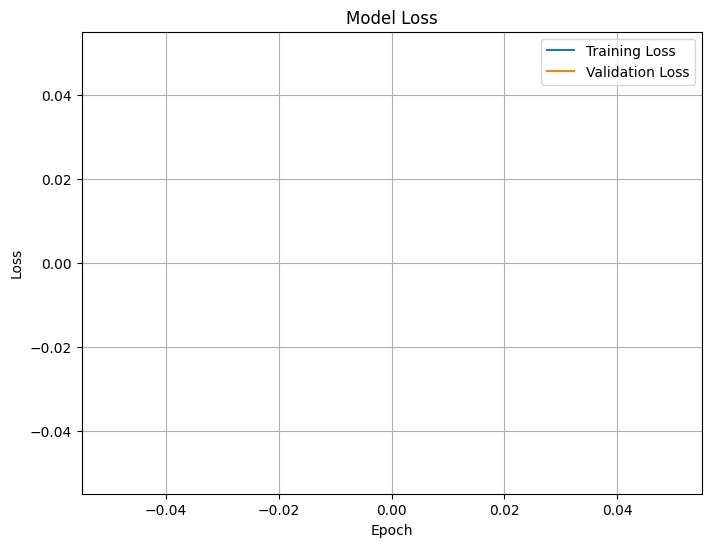

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Train and test + Grid Search

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train():
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        all_preds.append(out.argmax(dim=1).cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    train_loss = epoch_loss / len(train_loader)

    return accuracy, train_loss, f1

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = F.cross_entropy(out, data.y)
            total_loss += loss.item()
            all_preds.append(out.argmax(dim=1).cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # Calculate metrics
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average="weighted")
    val_loss = total_loss / len(loader)

    return accuracy, val_loss, f1, all_preds, all_labels

In [ ]:

num_layers_list = [2, 3, 4]
hidden_dims_list = [32, 64, 128]
norm_types_list = ["layer", "node_n", "node_v", "node_m","node_srv","node_pr_2"] #
param_grid = list(product(num_layers_list, hidden_dims_list, norm_types_list))

best_val_acc = 0
best_params = None
best_model_path = "best_grid_model_1.pt"
results = []


for num_layers, hidden_dim, norm_type in param_grid:
    print(f"\nTraining with num_layers={num_layers}, hidden_dim={hidden_dim}, norm_type={norm_type}")

    set_seed(42)

    model = GCN(dataset.num_features, hidden_dim=hidden_dim, output_dim=dataset.num_classes, num_layers=num_layers, norm_type=norm_type)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    patience = 20
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(100):
        train_acc, train_loss, train_f1 = train()
        val_acc, val_loss, val_f1, _, _ = evaluate(val_loader)

        # print(
        #     f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
        #     f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}"
        # )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "temp_model_1.pt")  # Save the best model for this config
            print(f"Saved best model at epoch {epoch} with Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Load best model for this configuration
    model.load_state_dict(torch.load("temp_model_1.pt"))
    test_acc, test_loss, test_f1,_,_ = evaluate(test_loader)

    print(f"For num_layers={num_layers}, hidden_dim={hidden_dim}, norm_type={norm_type}: Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")
    results.append({
                "num_layers": num_layers,
                "hidden_dim": hidden_dim,
                "norm_type": norm_type,
                "test_accuracy": test_acc,
                "test_loss": test_loss,
                "test_f1": test_f1
            })
    # Update best model if current one is better
    if test_acc > best_val_acc:
        best_val_acc = test_acc
        best_params = (num_layers, hidden_dim, norm_type)
        torch.save(model.state_dict(), best_model_path)  # Save the best model

# Final results
print(f"\nBest Model: num_layers={best_params[0]}, hidden_dim={best_params[1]},  norm_type={best_params[2]} with Accuracy={best_val_acc:.4f}")
df_results = pd.DataFrame(results)
df_results_correct = df_results['test_accuracy'].round(4)*100
df_results_correct



Training with num_layers=2, hidden_dim=32, norm_type=layer
Saved best model at epoch 0 with Train Loss: 0.6989, Train Accuracy: 0.4962, Train F1: 0.4418, Val Loss: 0.6652, Val Accuracy: 0.5723, Val F1: 0.4476
Saved best model at epoch 1 with Train Loss: 0.6895, Train Accuracy: 0.5278, Train F1: 0.4968, Val Loss: 0.6639, Val Accuracy: 0.5602, Val F1: 0.4023
Saved best model at epoch 14 with Train Loss: 0.6930, Train Accuracy: 0.5263, Train F1: 0.5200, Val Loss: 0.6615, Val Accuracy: 0.5602, Val F1: 0.4023
Saved best model at epoch 22 with Train Loss: 0.6799, Train Accuracy: 0.5624, Train F1: 0.5325, Val Loss: 0.6559, Val Accuracy: 0.5422, Val F1: 0.4221
Saved best model at epoch 24 with Train Loss: 0.6719, Train Accuracy: 0.5594, Train F1: 0.5465, Val Loss: 0.6497, Val Accuracy: 0.5602, Val F1: 0.4023
Saved best model at epoch 25 with Train Loss: 0.6728, Train Accuracy: 0.5714, Train F1: 0.5584, Val Loss: 0.6455, Val Accuracy: 0.5964, Val F1: 0.5849
Saved best model at epoch 27 with Tr

,test_accuracy
0,63.86
1,62.05
2,61.45
3,54.82
4,59.64
5,59.04
6,59.04
7,59.64
8,61.45
9,59.64


In [ ]:
df_results = pd.DataFrame(results)
df_results

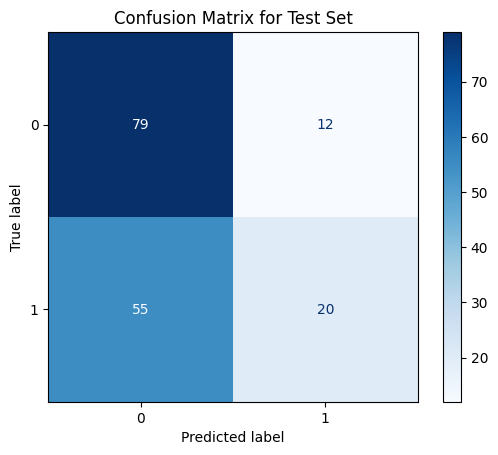

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Set")
plt.show()


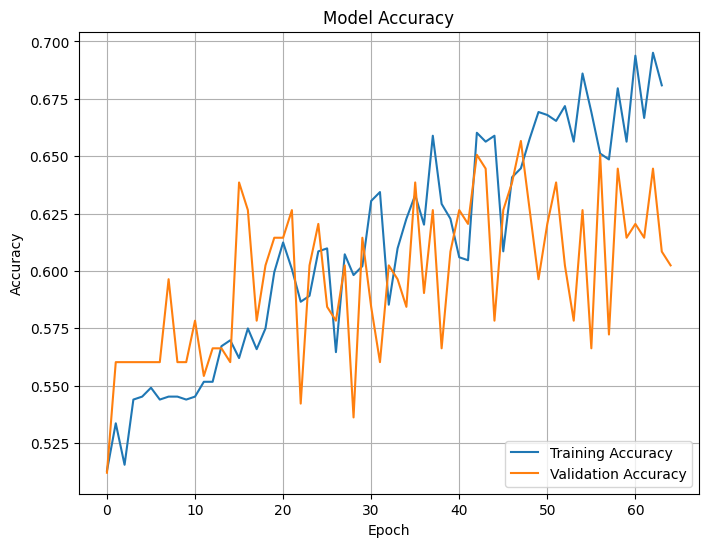

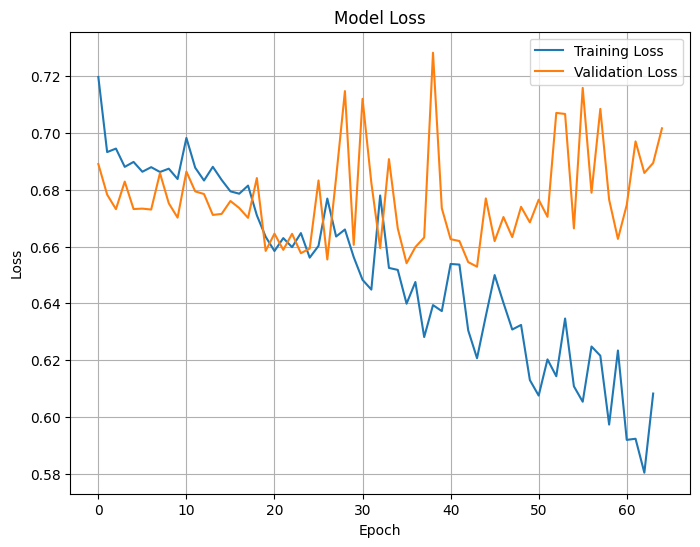

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()